## SimulateInterferometer.ipynb

‹ SimulateInterferometer.ipynb › Copyright (C) ‹ 2019 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk › 

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

**This notebook was created for the CHPC/NITheP [2019 Chris Engelbrecht Summer School](https://quantum.ukzn.ac.za/2019-chris-engelbrecht-summer-school/) on the Foundations of Theoretical and Computational Science.**

---

First we import some libraries:

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import cv2

Then define a constant we're going to use many times:

In [2]:
const_c = 3e8   # speed of light [m/s]

---

We're going to simulate some data for the VLA telescope in D-array, its most compact configuration. The diameter of a VLA dish is 25m and we're going to simulate a monochromatic observation at a frequency of 5GHz.

In [3]:
D = 25                         # diameter of dish [metres]
frequency = 5e9                # observing frequency [Hz]
wavelength = const_c/frequency # receiving wavelength [metres]

We can work out the reception pattern of an individual dish, known as the *primary beam*, using 

$$ \Delta \theta_{\rm pb} = \frac{\lambda}{D} $$

which returns the angle in radians.

Note: sometimes you will see a pre-factor infront of this equation (e.g. $1.22\,\lambda/D$ or $1.02$ or $1.15$ ...). This pre-factor depends on the illumination of the dish by the receiver, which can be changed by (e.g.) tapering the edges of a parabolic dish.

In [4]:
FoV = wavelength/D              # Field of View [rads]
print('Field of View =', round(FoV*180./np.pi, 2) ,'degrees')

Field of View = 0.14 degrees


Now we should define the distribution of our antennas on the ground. Note that radio astronomers say "antennas" rather than "antennae".

We're going to pretend that we're using the VLA telescope in D-array (most compact configuration). The positions of the antennas are described [here](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/ant_positions.pdf). I've provided them as CSV files. The VLA has three "arms": North, South West and South East.

In [5]:
vla_north = pd.read_csv('data/VLA_North.csv')
vla_swest = pd.read_csv('data/VLA_SWest.csv')
vla_seast = pd.read_csv('data/VLA_SEast.csv')

The positions of the radio antennas are provided in units of nanoseconds. We can convert these into units of number of wavelengths:

$$ b\,{\rm [\lambda]} = 10^{-9}\frac{\rm c}{\lambda}\times b\,{\rm [ns]} $$.

In [6]:
W = 1e-9/wavelength*const_c*np.array(vla_swest) # [number of wavelengths]
E = 1e-9/wavelength*const_c*np.array(vla_seast) 
N = 1e-9/wavelength*const_c*np.array(vla_north) 

Let's check that the layout looks about right...

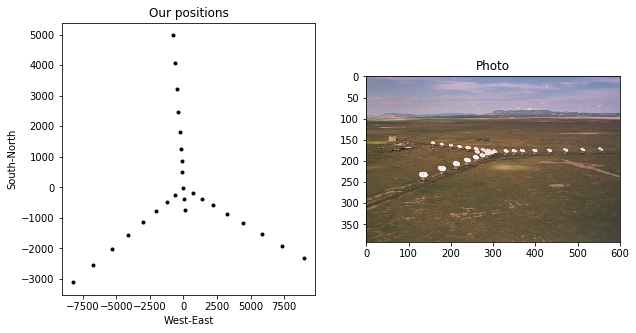

In [7]:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.title('Our positions') 
pl.xlabel('West-East') 
pl.ylabel('South-North')
pl.plot(W[:,1], -W[:,0], 'k.', E[:,1], -E[:,0], 'k.', N[:,1], -N[:,0], 'k.')
pl.subplot(122) 
vla = cv2.imread('./images/VLA-D_lo.jpg')
pl.title('Photo') 
pl.imshow(cv2.cvtColor(vla, cv2.COLOR_BGR2RGB))

In [8]:
vla_d = np.vstack((vla_swest,vla_seast,vla_north)) # make a single array of all antenna positions

XYZ_baselines = []                                                                  
for i in range(len(vla_d)):                                                         
    for j in range(i+1,len(vla_d)):
        XYZ_baselines.append(np.subtract(vla_d[i], vla_d[j])) # (u,v)
        XYZ_baselines.append(np.subtract(vla_d[j], vla_d[i])) # (-u,-v)     

XYZ_baselines = np.array(XYZ_baselines)
print("No. of baselines in (u,v) plane:", int(len(XYZ_baselines)/2)) 

No. of baselines in (u,v) plane: 351




The sampling in Fourier space $(u,v,w)$ is calculated by transforming each XYZ baseline, $\textbf{B}$, into the plane perpendicular to the source direction (i.e. the *projected* baseline) using:

 $\begin{bmatrix}
                 u \\
                 v \\
                 w \\ 
              \end{bmatrix} = \begin{bmatrix} 
        \sin{H} &\cos{H} &0 \\
        -\sin{\delta}\cos{H} &\sin{\delta}\sin{H} &\cos{\delta} \\
        \cos{\delta}\cos{H} &-\cos{\delta}\sin{H} &\sin{\delta} 
     \end{bmatrix} 
 \begin{bmatrix}
                 B_{x} \\
                 B_{y} \\
                 B_{z} \\ 
              \end{bmatrix}$,
              
[Eq. 4.1](https://link.springer.com/chapter/10.1007/978-3-319-44431-4_4) of Thompson, Moran & Swenson.

Here we have defined the source direction ($\textbf{s}$) in terms of its position in Hour Angle ($H$) and declination ($\delta$). Normally astronomical source positions are defined in the [Equatorial co-ordinate system](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) in terms of Right Ascension and declination; the Hour Angle is the angular difference between the Right Ascension ($RA$) of the source and the Local Sidereal Time (LST) at the telescope, which depends on the longitude of the telescope, expressed in hours:

$$HA = LST - RA $$

see [Fig 4.2](https://link.springer.com/chapter/10.1007/978-3-319-44431-4_4) of TMS. 

As the Earth rotates, 15 degrees of the sky will be swept over in one hour. We'll assume that we're making a one hour-long observation, $-0.5 < H < 0.5$, which means that the astronomical pointing direction moves across the local celestial medidian. We'll make a data sample every 6 minutes (0.1 hours).

I'm going to choose a declination for the source direction of $\delta = 45$ degrees. 

**Note:** You might want to investigate how your *uv*-sampling pattern changes if you alter the declination of the source. 

In [9]:
HA = np.arange(-0.5*15.*(np.pi/180.), 0.5*15.*(np.pi/180.), 0.1*(np.pi/180.))  # [radians]
dec = np.pi/4.                                                                 # [radians]

We can calculate the rotation matrix for each step in hour angle:

In [10]:
def calc_R(H,dec):
    
    """
    function to calculate rotation matrix
    """
    
    R = [[np.sin(H), np.cos(H), 0],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec)]]
    
    return np.array(R)

First let's see how the *uv*-sampling looks for a single time step. We call individual time steps *snapshots*. Note that the numpy library has a built in function for calculating the inner product - very useful!

In [11]:
UV_snapshot=[]
for j in range(len(XYZ_baselines)):
    R = calc_R(0.,dec) # rotation matrix for HA = 0.0
    UV_snapshot.append(np.dot(R, XYZ_baselines[j]))
    
UV_snapshot = np.array(UV_snapshot)

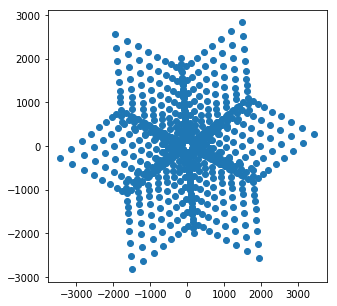

In [12]:
pl.figure(figsize=(5, 5))
pl.scatter(UV_snapshot[:,0],UV_snapshot[:,1])

Now let's look at the uv-coverage for the whole 1 hour observation. We just add in a loop over the hour angle steps:

In [13]:
UV_coverage=[]
for i in range(len(HA)):
    for j in range(len(XYZ_baselines)):
        R = calc_R(HA[i],dec) 
        UV_coverage.append(np.dot(R, XYZ_baselines[j]))
    
UV_coverage = np.array(UV_coverage)

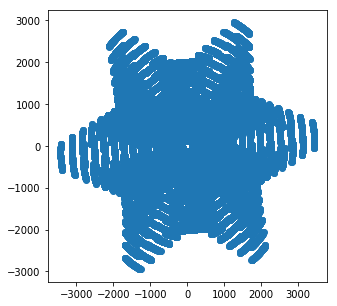

In [14]:
pl.figure(figsize=(5, 5))
pl.scatter(UV_coverage[:,0],UV_coverage[:,1])

**Note:** You might want to investigate how your *uv*-sampling pattern changes if you increase the length of the observation.

---

#### Exercise 1: the Point Spread Function

The first exercise is to calculate the point spread function (PSF), also known as the *synthesized beam*. To do this we need to grid and FFT our simulated continuous visibilities. 

To start with we'll make an empty grid. The pixel size in our uv-grid will determine the field-of-view in the final image and the uv-limit of our grid will determine the pixel size in our final image. So we have to set these carefully.


In [15]:
npix = 256                       # number of pixels on side of grid

# Fourier (uv) space:
uvmax = 4000.
uvcell = 2*uvmax/float(npix)

# image space:
imsize = (1/uvcell)*(180./np.pi)
cellsize = imsize/np.float(npix) # [rads]

Remember that our visibility response is a complex valued function, so we need to make a complex grid:

In [16]:
uvgrid = np.zeros((npix, npix)) + 1j*np.zeros((npix, npix))

We're going to loop through our sample co-ordinates and allocate each one to the nearest pixel in our grid. 

In [17]:
for i in range(UV_coverage.shape[0]):
    u_pixel = int(np.floor(0.5 + UV_coverage[i,0]/uvcell) + npix/2)
    v_pixel = int(np.floor(0.5 + UV_coverage[i,1]/uvcell) + npix/2)
    uvgrid[v_pixel, u_pixel] += 1.0 + 1j*0.0

...and let's plot it. The imaginary part should be zero.

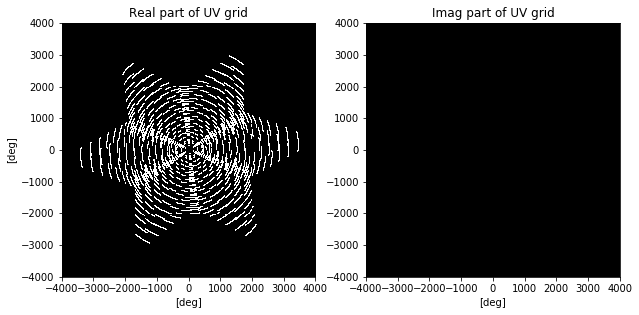

In [18]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part of UV grid');
pl.xlabel(r'[deg]');
pl.ylabel(r'[deg]');
pl.imshow(uvgrid.real, origin='lower', vmax = 1, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])
pl.subplot(122)
pl.title('Imag part of UV grid');
pl.xlabel(r'[deg]');
#pl.ylabel(r'[deg]');
pl.imshow(uvgrid.imag, origin='lower', vmax = 1, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])

Now we perform the FFT. Two things to note:

* this is an *inverse* FFT, and
* the FFT happens in **two stages**: the first step does a 2d FFT and the second step re-centres the quadrants, this is known as the "FFT shift". 

We haven't bothered to normalise the FFT yet at this point, so we use the peak value of the output to do that.

In [19]:
psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(uvgrid)))

fft_norm = np.max(psf.real)
psf/= fft_norm

...and let's see what it looks like. We'll plot the imaginary part too in case there are any artefacts. Note that even if it's worked perfectly the imaginary part will not be identically zero - it will be noisy but at a very low level $(<10^{-10})$ due to the finite precision of the algorithm.

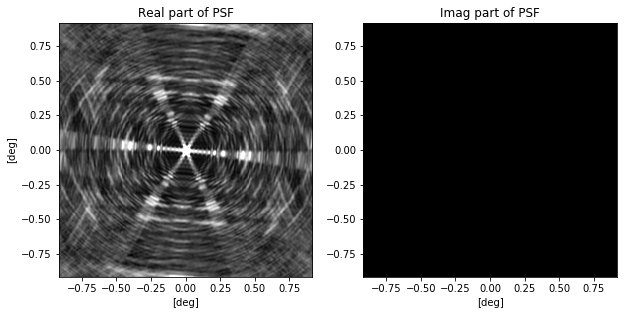

In [20]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part of PSF');
pl.xlabel(r'[deg]');
pl.ylabel(r'[deg]');
pl.imshow(psf.real,vmax=0.1,cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])
pl.subplot(122)
pl.title('Imag part of PSF');
pl.xlabel(r'[deg]');
#pl.ylabel(r'[deg]');
pl.imshow(psf.imag,vmax=0.1,cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])

---

#### Exercise 2: the Aliasing Problem

In this exercise we're going to simulate the response of a telescope to a source *outside the imaged field-of-view*. We're going to see the effect of employing an FFT for imaging without using an anti-aliasing kernel. 

To do this we're going to use a sky brightness distribution that is composed only of compact, i.e. "point-like", radio sources and we're going to calculate the interferometer response analytically.

From the first lecture, you'll have seen that the interferometer response (van Cittert-Zernicke theorem) is given by

$$ V(u,v) = \int{ S(l,m)\, {\rm e}^{-2\pi i(ul + vm)}\,{\rm d}l\,{\rm d}m }.$$

For point-like sources we can say,

$$ S(l,m) = S_0\, \delta(l-l_0, m-m_0), $$

where $S_0$ is the amplitude of the source, which is at location $(l_0,m_0)$. The co-ordinates $(l,m)$ are *direction cosines* on the celestial sphere - basically the separation of the source position from the zero phase point in units of angle.

Our visibility response is therefore:

$$ V(u,v) = \int{ S_0\, \delta(l-l_0, m-m_0)\, {\rm e}^{-2\pi i(ul + vm)}\,{\rm d}l\,{\rm d}m } = S_0\,{\rm e}^{-2\pi i(ul_0 + vm_0)}.$$

For example, say we wanted to calculate the response to a 100 Jansky source half a degree away from the phase centre. First we define the source parameters: 

In [21]:
l0 = 0.01; m0 = 0.01    # [rads]
src_lmn = np.array([l0, m0 , np.sqrt(1 - l0**2 - m0**2)-1.])
s0 = 100.0

Then we calculate the visibility response for each baseline's $(u,v,w)$ sample in our snapshot and put them into an array:

In [22]:
V_uv=[]
for i in range(UV_coverage.shape[0]):
    basel_uvw = UV_coverage[i,:]
    vis = s0*np.exp(-2j*np.pi* np.dot(basel_uvw, src_lmn))
    V_uv.append(vis)
    
V_uv = np.array(V_uv)

At this point we have the same kind of data that most radio observatories would deliver to the astronomer who requested the observation: a dataset of *continuous visibilities*, which are regularly sampled in time and frequency.

To make an image from our visibility dataset we need to follow the steps from Lecture 2: we need to grid the visibilities onto a regular grid in $(u,v)$ and then perform an FFT.

Let's start with the gridding. From the lecture, you should remember that we normally need to grid using a convolution kernel to avoid aliasing. Here we're going to demonstrate why this is necessary and ignore the anti-aliasing kernel. We're simply going to grid our visibility data by allocating each sample into the nearest grid cell.

In [23]:
npix = 256                       # number of pixels on side of grid

# Fourier (uv) space:
uvmax = 4000.
uvcell = 2*uvmax/float(npix)

# image space:
imsize = (1/uvcell)*(180./np.pi)
cellsize = imsize/np.float(npix) # [rads]

Just as for the PSF, we need to make a complex grid:

In [24]:
uvgrid2 = np.zeros((npix, npix)) + 1j*np.zeros((npix, npix))

Now let's allocate our continuous visibilities onto the grid:

In [25]:
for i in range(UV_coverage.shape[0]):
    u_pixel = int(np.floor(0.5 + UV_coverage[i,0]/uvcell) + npix/2)
    v_pixel = int(np.floor(0.5 + UV_coverage[i,1]/uvcell) + npix/2)
    uvgrid2[v_pixel, u_pixel] += V_uv[i]

...and see what it looks like:

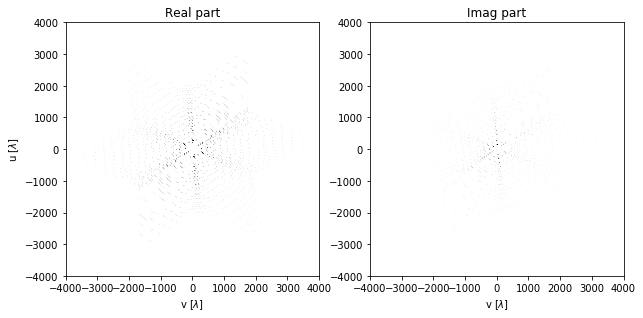

In [26]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part');
pl.xlabel(r'v [$\lambda$]');
pl.ylabel(r'u [$\lambda$]');
pl.imshow(uvgrid2.real, origin='lower', vmax = 0.001, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])
pl.subplot(122)
pl.title('Imag part');
pl.xlabel(r'v [$\lambda$]');
#pl.ylabel(r'u [$\lambda$]');
pl.imshow(uvgrid2.imag, origin='lower', vmax = 1, cmap='gray', extent=[-uvmax,uvmax,-uvmax,uvmax])

Now we can make an image. Remember to normalise it using the value we found from the PSF:

In [27]:
dirty_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(uvgrid2)))
dirty_image/= fft_norm

...and let's see what it looks like:

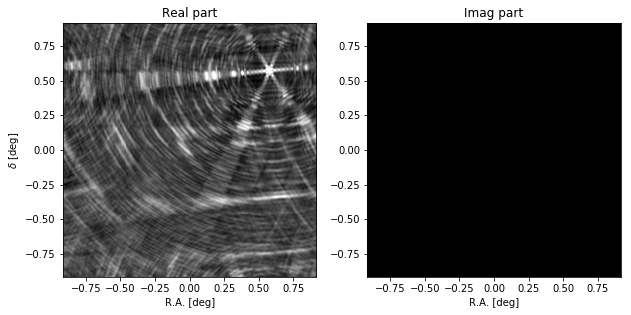

In [28]:
pl.figure(figsize=(10, 10))
pl.subplot(121)
pl.title('Real part');
pl.xlabel(r'R.A. [deg]');
pl.ylabel(r'$\delta$ [deg]');
pl.imshow(dirty_image.real, origin='lower', vmax = 10, cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])
pl.subplot(122)
pl.title('Imag part');
pl.xlabel(r'R.A. [deg]');
#pl.ylabel(r'$\delta$ [deg]');
pl.imshow(dirty_image.imag, origin='lower', vmax = 10, cmap='gray', extent=[-imsize/2,imsize/2,-imsize/2,imsize/2])

Things to explore:
    
* What happens if you make an image with twice as many pixels? i.e. keep the uv-limit the same but half the uv-cellsize;

* What happens if you increase the direction cosine $l_0$? Can you make the source re-appear on the opposite side of the image?
* Can you introduce an anti-aliasing kernel to correct the gridding? (See Lecture 2 for suggested scipy routine)